In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
% matplotlib inline
plt.style.use('seaborn-whitegrid')

TRAIN_PATH = './train.csv'
TEST_PATH = './test.csv'

print(os.listdir("."))

['.cache', 'sample_submission.csv', 'Untitled.ipynb', '.sudo_as_admin_successful', 'ssl', '.bash_logout', '.ipython', '.jupyter', '.ipynb_checkpoints', 'GCP-Coupons-Instructions.rtf', 'train.csv', '.local', '.profile', 'train.csv.zip', 'test.csv', '.config', '.rnd', '.kaggle', '.nano', '.bashrc', '.ssh']


# Supporting functions

In [44]:
# For this plot and further analysis, we need a function to calculate the distance in miles between locations in lon,lat coordinates.
# This function is based on https://stackoverflow.com/questions/27928/
# calculate-distance-between-two-latitude-longitude-points-haversine-formula 
# return distance in miles

def add_time(df):
    # add time information
    df['year'] = df.pickup_datetime.apply(lambda t: t.year)
    df['weekday'] = df.pickup_datetime.apply(lambda t: t.weekday())
    df['hour'] = df.pickup_datetime.apply(lambda t: t.hour)
    
def distance(lat1, lon1, lat2, lon2):
    p = 0.017453292519943295 # Pi/180
    a = 0.5 - np.cos((lat2 - lat1) * p)/2 + np.cos(lat1 * p) * np.cos(lat2 * p) * (1 - np.cos((lon2 - lon1) * p)) / 2
    return 0.6213712 * 12742 * np.arcsin(np.sqrt(a)) # 2*R*asin...

def add_travel_vector_features(df):
    # add new column to dataframe with distance in miles
    df['distance_miles'] = distance(df.pickup_latitude, df.pickup_longitude, \
                                          df.dropoff_latitude, df.dropoff_longitude)
    #df['abs_diff_longitude'] = (df.dropoff_longitude - df.pickup_longitude).abs()
    #df['abs_diff_latitude'] = (df.dropoff_latitude - df.pickup_latitude).abs()
    #df['abs_diff_lon_lat'] = (df.abs_diff_longitude + df.abs_diff_latitude)

def add_airport_dist(df):
    """
    Return minumum distance from pickup or dropoff coordinates to each airport.
    JFK: John F. Kennedy International Airport
    EWR: Newark Liberty International Airport
    LGA: LaGuardia Airport
    """
    jfk_coord = (40.639722, -73.778889)
    ewr_coord = (40.6925, -74.168611)
    lga_coord = (40.77725, -73.872611)
    
    pickup_lat = df['pickup_latitude']
    dropoff_lat = df['dropoff_latitude']
    pickup_lon = df['pickup_longitude']
    dropoff_lon = df['dropoff_longitude']
    
    pickup_jfk = distance(pickup_lat, pickup_lon, jfk_coord[0], jfk_coord[1]) 
    dropoff_jfk = distance(jfk_coord[0], jfk_coord[1], dropoff_lat, dropoff_lon) 
    pickup_ewr = distance(pickup_lat, pickup_lon, ewr_coord[0], ewr_coord[1])
    dropoff_ewr = distance(ewr_coord[0], ewr_coord[1], dropoff_lat, dropoff_lon) 
    pickup_lga = distance(pickup_lat, pickup_lon, lga_coord[0], lga_coord[1]) 
    dropoff_lga = distance(lga_coord[0], lga_coord[1], dropoff_lat, dropoff_lon) 
    
    df['jfk_dist'] = pd.concat([pickup_jfk, dropoff_jfk], axis=1).min(axis=1)
    df['ewr_dist'] = pd.concat([pickup_ewr, dropoff_ewr], axis=1).min(axis=1)
    df['lga_dist'] = pd.concat([pickup_lga, dropoff_lga], axis=1).min(axis=1)

def add_features(df):
    add_time(df)
    add_travel_vector_features(df)
    add_airport_dist(df)
    
    return df

def clean_df(df):
    print('Old size: %d' % len(df))
    
    # Remove observations with missing values
    df.dropna(how='any', axis='rows', inplace=True)

    # Removing observations with erroneous values
    mask = df['pickup_longitude'].between(-75, -73)
    mask &= df['dropoff_longitude'].between(-75, -73)
    mask &= df['pickup_latitude'].between(40, 42)
    mask &= df['dropoff_latitude'].between(40, 42)
    mask &= df['passenger_count'].between(0, 6)
    mask &= df['fare_amount'].between(0, 250)
    mask &= df['distance_miles'].between(0.05, 100)

    df = df[mask]
    
    print('New size: %d' % len(df))
    
    return df

***

# Train XGB with default settings

In [115]:
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.grid_search import GridSearchCV
import xgboost as xgb

In [116]:
%%time

df_train =  pd.read_csv(TRAIN_PATH, nrows = 10000000)
df_train['pickup_datetime'] = df_train['pickup_datetime'].str.slice(0, 16)
df_train['pickup_datetime'] = pd.to_datetime(df_train['pickup_datetime'], utc=True, format='%Y-%m-%d %H:%M')

CPU times: user 21.9 s, sys: 1.06 s, total: 23 s
Wall time: 23 s


In [119]:
df_train.head()

,key,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
0,2009-06-15 17:26:21.0000001,4.5,2009-06-15 17:26:00+00:00,-73.844311,40.721319,-73.841610,40.712278,1
1,2010-01-05 16:52:16.0000002,16.9,2010-01-05 16:52:00+00:00,-74.016048,40.711303,-73.979268,40.782004,1
2,2011-08-18 00:35:00.00000049,5.7,2011-08-18 00:35:00+00:00,-73.982738,40.761270,-73.991242,40.750562,2
3,2012-04-21 04:30:42.0000001,7.7,2012-04-21 04:30:00+00:00,-73.987130,40.733143,-73.991567,40.758092,1
4,2010-03-09 07:51:00.000000135,5.3,2010-03-09 07:51:00+00:00,-73.968095,40.768008,-73.956655,40.783762,1


In [120]:
%%time

df_train = add_features(df_train)
df_train = clean_df(df_train)

Old size: 10000000
New size: 9632462
CPU times: user 41.4 s, sys: 4.53 s, total: 45.9 s
Wall time: 45.9 s


In [46]:
cols = ['pickup_longitude', 'pickup_latitude', 'dropoff_longitude', 'dropoff_latitude', 'passenger_count', 'year', 'weekday', 'hour', 'distance_miles', 'jfk_dist', 'ewr_dist', 'lga_dist']
X = df_train[cols]
y = df_train['fare_amount']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.05)

matrix_train = xgb.DMatrix(X_train,label=y_train)
matrix_test = xgb.DMatrix(X_test,label=y_test)

In [122]:
%%time

params = {
    'objective':'reg:linear',
    'eval_metric':'rmse',
    'silent': 1,
    'nthread': 8,
    'n_jobs': 8,
}

model1 = xgb.train(
    params=params,
    dtrain=matrix_train,
    num_boost_round=1000,
    early_stopping_rounds=10,
    evals=[(matrix_test,'test')],
)

[0]	test-rmse:10.4118
Will train until test-rmse hasn't improved in 10 rounds.
[1]	test-rmse:7.7467
[2]	test-rmse:6.00556
[3]	test-rmse:4.9146
[4]	test-rmse:4.26842
[5]	test-rmse:3.89442
[6]	test-rmse:3.68334
[7]	test-rmse:3.56883
[8]	test-rmse:3.50567
[9]	test-rmse:3.45361
[10]	test-rmse:3.42722
[11]	test-rmse:3.40657
[12]	test-rmse:3.39465
[13]	test-rmse:3.37517
[14]	test-rmse:3.36161
[15]	test-rmse:3.35435
[16]	test-rmse:3.3441
[17]	test-rmse:3.33875
[18]	test-rmse:3.33258
[19]	test-rmse:3.32046
[20]	test-rmse:3.31619
[21]	test-rmse:3.30979
[22]	test-rmse:3.3069
[23]	test-rmse:3.30287
[24]	test-rmse:3.29621
[25]	test-rmse:3.29512
[26]	test-rmse:3.29398
[27]	test-rmse:3.2886
[28]	test-rmse:3.28498
[29]	test-rmse:3.28464
[30]	test-rmse:3.27978
[31]	test-rmse:3.27816
[32]	test-rmse:3.27069
[33]	test-rmse:3.26742
[34]	test-rmse:3.25998
[35]	test-rmse:3.25852
[36]	test-rmse:3.26013
[37]	test-rmse:3.25896
[38]	test-rmse:3.25657
[39]	test-rmse:3.25421
[40]	test-rmse:3.24992
[41]	test-rmse:

### Verify performance of training against validation set

In [123]:
from sklearn.metrics import mean_squared_error
import math

y_pred_default = model1.predict(matrix_test, ntree_limit=model1.best_ntree_limit)
print('Score:', math.sqrt(mean_squared_error(y_test, y_pred_default)))

Score: 3.1284596965498364


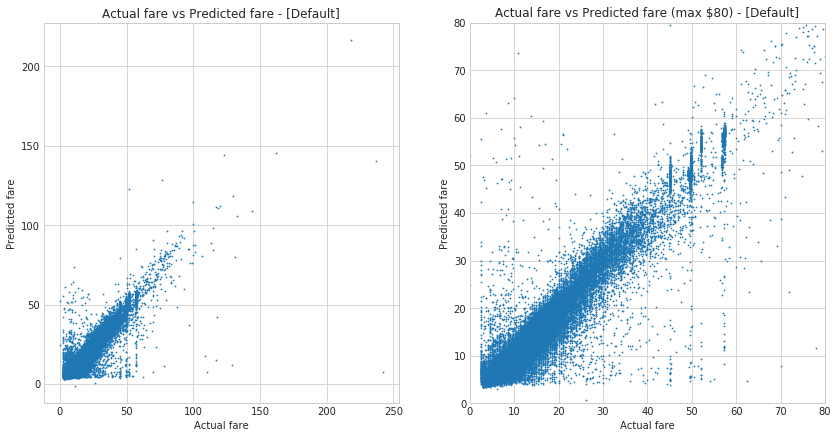

In [135]:
# plot prediction and actual data

plt.figure(figsize=(14,7))
plt.subplot(1, 2, 1)
plt.plot(y_test, y_pred_default, '.', markersize=1.5)
plt.title('Actual fare vs Predicted fare - [Default]')
plt.xlabel('Actual fare')
plt.ylabel('Predicted fare')

plt.subplot(1, 2, 2)
plt.plot(y_test, y_pred_default, '.', markersize=1.5)
plt.title('Actual fare vs Predicted fare (max $80) - [Default]')
plt.xlabel('Actual fare')
plt.ylabel('Predicted fare')
plt.xlim(0, 80)
plt.ylim(0, 80)

plt.show()

***

# GridSearch for Tuning

In [49]:
xgb_model = xgb.XGBRegressor(
    objective='reg:linear',
    eval_metric ='rmse',
    nthread = 8,
    n_jobs= 8,
    silent = 1,
)

param_grid = {
    'n_estimators': [250],
    'max_depth': [7],
    'learning_rate': [0.075],
    'subsample': [0.9],
    'colsample_bytree': [0.8],
    'colsample_bylevel': [0.6],
    'min_child_weight': [2]
}

# Run Grid Search process
fit_params = {
    #'eval_metric': 'rmse',
    'verbose': 0,
    'early_stopping_rounds': 10,
    'eval_set': [(X_test, y_test)]
}
 
gs_reg = GridSearchCV(
    xgb_model, 
    param_grid, 
    #n_jobs=1, 
    #cv=n_folds,
    fit_params=fit_params,
    scoring='neg_mean_squared_error',
    verbose=1,
    cv=2
)

grid_result = gs_reg.fit(X_train, y_train)

gs_reg.grid_scores_

Fitting 2 folds for each of 1 candidates, totalling 2 fits


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:   33.1s finished


[mean: -10.30879, std: 0.01726, params: {'colsample_bylevel': 0.6, 'max_depth': 7, 'n_estimators': 250, 'subsample': 0.9, 'min_child_weight': 2, 'learning_rate': 0.075, 'colsample_bytree': 0.8}]

***

# Train XGB with tuned settings

In [136]:
%%time

df_train =  pd.read_csv(TRAIN_PATH, nrows = 10000000)
df_train['pickup_datetime'] = df_train['pickup_datetime'].str.slice(0, 16)
df_train['pickup_datetime'] = pd.to_datetime(df_train['pickup_datetime'], utc=True, format='%Y-%m-%d %H:%M')

CPU times: user 20.6 s, sys: 1.19 s, total: 21.8 s
Wall time: 21.8 s


In [137]:
df_train = add_features(df_train)
df_train = clean_df(df_train)

Old size: 10000000
New size: 9632462


In [138]:
cols = ['pickup_longitude', 'pickup_latitude', 'dropoff_longitude', 'dropoff_latitude', 'passenger_count', 'year', 'weekday', 'hour', 'distance_miles', 'jfk_dist', 'ewr_dist', 'lga_dist']
X = df_train[cols]
y = df_train['fare_amount']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.01)

matrix_train = xgb.DMatrix(X_train,label=y_train)
matrix_test = xgb.DMatrix(X_test,label=y_test)

print(len(y_test))

96325


In [139]:
%%time

params = {
    'objective':'reg:linear',
    'eval_metric':'rmse',
    #
    'max_depth': 7, #Result of tuning with CV
    'eta':.075, #Result of tuning with CV
    'subsample': 0.9, #Result of tuning with CV
    'colsample_bytree': 0.8, #Result of tuning with CV
    'colsample_bylevel': 0.6,
    'min_child_weight': 2,
    #
    'silent': 1,
    'nthread': 8,
    'n_jobs': 8,
}

model2 = xgb.train(
    params=params,
    dtrain=matrix_train,
    num_boost_round=1000,
    early_stopping_rounds=10,
    evals=[(matrix_test,'test')],
)

[13:15:53] Tree method is automatically selected to be 'approx' for faster speed. to use old behavior(exact greedy algorithm on single machine), set tree_method to 'exact'
[0]	test-rmse:13.3969
Will train until test-rmse hasn't improved in 10 rounds.
[1]	test-rmse:12.4805
[2]	test-rmse:11.6333
[3]	test-rmse:10.8514
[4]	test-rmse:10.146
[5]	test-rmse:9.48968
[6]	test-rmse:8.88133
[7]	test-rmse:8.32597
[8]	test-rmse:7.81443
[9]	test-rmse:7.3466
[10]	test-rmse:6.92434
[11]	test-rmse:6.53528
[12]	test-rmse:6.18369
[13]	test-rmse:5.88642
[14]	test-rmse:5.62226
[15]	test-rmse:5.35681
[16]	test-rmse:5.13576
[17]	test-rmse:4.94299
[18]	test-rmse:4.75631
[19]	test-rmse:4.58378
[20]	test-rmse:4.42312
[21]	test-rmse:4.30094
[22]	test-rmse:4.17152
[23]	test-rmse:4.07292
[24]	test-rmse:3.97105
[25]	test-rmse:3.87913
[26]	test-rmse:3.80014
[27]	test-rmse:3.72792
[28]	test-rmse:3.67238
[29]	test-rmse:3.61803
[30]	test-rmse:3.56939
[31]	test-rmse:3.52517
[32]	test-rmse:3.48981
[33]	test-rmse:3.46024
[

[338]	test-rmse:2.98761
[339]	test-rmse:2.98754
[340]	test-rmse:2.98743
[341]	test-rmse:2.98723
[342]	test-rmse:2.98711
[343]	test-rmse:2.98697
[344]	test-rmse:2.98639
[345]	test-rmse:2.98639
[346]	test-rmse:2.9859
[347]	test-rmse:2.98587
[348]	test-rmse:2.98548
[349]	test-rmse:2.98523
[350]	test-rmse:2.98521
[351]	test-rmse:2.98497
[352]	test-rmse:2.98504
[353]	test-rmse:2.98473
[354]	test-rmse:2.98457
[355]	test-rmse:2.98458
[356]	test-rmse:2.9844
[357]	test-rmse:2.98426
[358]	test-rmse:2.98417
[359]	test-rmse:2.98372
[360]	test-rmse:2.9837
[361]	test-rmse:2.98357
[362]	test-rmse:2.98329
[363]	test-rmse:2.98316
[364]	test-rmse:2.98298
[365]	test-rmse:2.98292
[366]	test-rmse:2.9828
[367]	test-rmse:2.98265
[368]	test-rmse:2.98245
[369]	test-rmse:2.98228
[370]	test-rmse:2.98225
[371]	test-rmse:2.98175
[372]	test-rmse:2.98184
[373]	test-rmse:2.9817
[374]	test-rmse:2.98166
[375]	test-rmse:2.98159
[376]	test-rmse:2.98151
[377]	test-rmse:2.98153
[378]	test-rmse:2.9816
[379]	test-rmse:2.9816

In [ ]:
'''xgb_reg = xgb.XGBRegressor(
    objective='reg:linear',
    eval_metric ='rmse',
    #
    max_depth = 7, #Result of tuning with CV
    eta =.075, #Result of tuning with CV
    subsample = 0.9, #Result of tuning with CV
    colsample_bytree = 0.8, #Result of tuning with CV
    colsample_bylevel = 0.6,
    min_child_weight = 2,
    #
    #
    nthread = 8,
    n_jobs= 8,
    silent = 1,
)

print(xgb_reg)

xgb_reg.fit(X_train, y_train)'''

### Verify performance of training against validation set

In [140]:
y_pred_tuned = model2.predict(matrix_test, ntree_limit=model2.best_ntree_limit)
print('Score:', math.sqrt(mean_squared_error(y_test, y_pred_tuned)))

Score: 2.9728745875190827


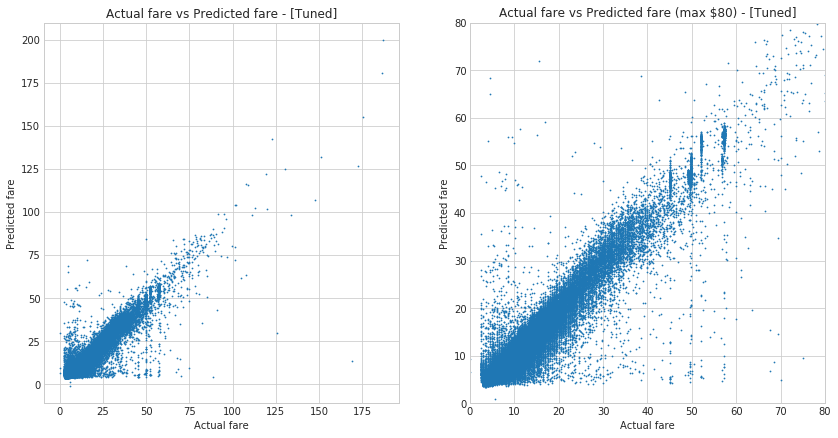

In [141]:
# plot prediction and actual data

plt.figure(figsize=(14,7))
plt.subplot(1, 2, 1)
plt.plot(y_test, y_pred_tuned, '.', markersize=1.5)
plt.title('Actual fare vs Predicted fare - [Tuned]')
plt.xlabel('Actual fare')
plt.ylabel('Predicted fare')

plt.subplot(1, 2, 2)
plt.plot(y_test, y_pred_tuned, '.', markersize=1.5)
plt.title('Actual fare vs Predicted fare (max $80) - [Tuned]')
plt.xlabel('Actual fare')
plt.ylabel('Predicted fare')
plt.xlim(0, 80)
plt.ylim(0, 80)

plt.show()

# Make predictions on the test set

In [147]:
df_test =  pd.read_csv(TEST_PATH)
df_test['pickup_datetime'] = df_test['pickup_datetime'].str.slice(0, 16)
df_test['pickup_datetime'] = pd.to_datetime(df_test['pickup_datetime'], utc=True, format='%Y-%m-%d %H:%M')

add_features(df_test)

cols = ['pickup_longitude', 'pickup_latitude', 'dropoff_longitude', 'dropoff_latitude', 'passenger_count', 'year', 'weekday', 'hour', 'distance_miles', 'jfk_dist', 'ewr_dist', 'lga_dist']
X_test = df_test[cols]

X_test.head()

,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,year,weekday,hour,distance_miles,jfk_dist,ewr_dist,lga_dist
0,-73.973320,40.763805,-73.981430,40.743835,1,2015,1,13,1.443607,12.819377,10.424234,5.351000
1,-73.986862,40.719383,-73.998886,40.739201,1,2015,1,13,1.507044,12.208516,9.455977,7.112463
2,-73.982524,40.751260,-73.979654,40.746139,1,2011,5,11,0.384398,12.832843,10.556347,6.000188
3,-73.981160,40.767807,-73.990448,40.751635,1,2012,5,21,1.218529,13.513499,10.184917,5.717171
4,-73.966046,40.789775,-73.988565,40.744427,1,2012,5,21,3.347514,13.152839,10.088114,4.964186


In [148]:
pred_test_default = model1.predict(xgb.DMatrix(X_test), ntree_limit = model1.best_ntree_limit)
pred_test_tuned = model2.predict(xgb.DMatrix(X_test), ntree_limit = model2.best_ntree_limit)

In [149]:
#Create submission file
submission_default = pd.DataFrame({
        "key": df_test['key'],
        "fare_amount": pred_test_default.round(2)
})

submission_tuned = pd.DataFrame({
        "key": df_test['key'],
        "fare_amount": pred_test_tuned.round(2)
})

submission_default = submission_default[['key', 'fare_amount']]
submission_tuned = submission_tuned[['key', 'fare_amount']]

submission_default.to_csv('taxi_fare_submission_default.csv',index=False)
submission_tuned.to_csv('taxi_fare_submission_tuned.csv',index=False)

In [150]:
submission_default.head()

,key,fare_amount
0,2015-01-27 13:08:24.0000002,10.89
1,2015-01-27 13:08:24.0000003,11.77
2,2011-10-08 11:53:44.0000002,4.35
3,2012-12-01 21:12:12.0000002,7.45
4,2012-12-01 21:12:12.0000003,13.92


In [151]:
submission_tuned.head()

,key,fare_amount
0,2015-01-27 13:08:24.0000002,10.80
1,2015-01-27 13:08:24.0000003,11.43
2,2011-10-08 11:53:44.0000002,4.20
3,2012-12-01 21:12:12.0000002,7.67
4,2012-12-01 21:12:12.0000003,13.56
